# Determination and Modelling of the Local Geoid in the Carpathian Region

Author: **Marcin Sikorski**<br>
Date: August, 2022

**Abstract**

The height obtained through surveying (GNSS, levelling, or any other method) is the ellipsoidal height and to have an efficient application in physical geodesy it has to be converted into geoid or orthometric height. This notebook aims to determine a local geoid model for Carpathian Mountains (in Central Europe) based on the known topographic height and assessing the precision performance of the Earth gravitational model (EGM2008) in the area of interest. The cubic interpolation was implemented for plotting a local geoid model based on satellite altimetry. The main result of this repository is a map of Carpathians local geoid.

**Keywords:** geoid modelling, Earth gravitational model (EGM), orthometric height, undulation, geodesy.

**Table of Contents:**
1. Gravity Anomaly Map
2. Elevation Map
3. Geoid Undulation Map
4. Geoid's Profiles
5. Conclusions

**Dataset Description**

The geophysical datasets for this repository were extracted from [Topex][1] website with global 1' grids in ASCII XYZ-format. Gravity is a V29.1 model from CryoSat-2 and Jason-1 satellite missions. Topography points are from satellite altimetry (V19.1).

The range of study area was defined as 43.0&deg;N, 16.0&deg;E for bottom left corner and 51.0&deg;N, 28.0&deg;W for upper right corner.

[1]: https://topex.ucsd.edu/cgi-bin/get_data.cgi 'Topex'

In [1]:
# importing modules
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing data points
df_grav = pd.read_csv('carpathians_gravity.txt', sep=';', names=['long', 'lat', 'grav'])
df_elev = pd.read_csv('carpathians_topography.txt', sep=';', names=['long', 'lat', 'elev'])

# combining into one dataframe
df = pd.merge(df_elev, df_grav, on=['long', 'lat'])
df.head(10)

,long,lat,elev,grav
0,16.0083,50.9968,393.0,33.3
1,16.0250,50.9968,383.0,33.1
2,16.0417,50.9968,367.0,32.4
3,16.0583,50.9968,351.0,31.1
4,16.0750,50.9968,349.0,29.4
5,16.0917,50.9968,329.0,27.2
6,16.1083,50.9968,371.0,24.7
7,16.1250,50.9968,367.0,22.1
8,16.1417,50.9968,287.0,19.5
9,16.1583,50.9968,237.0,17.2


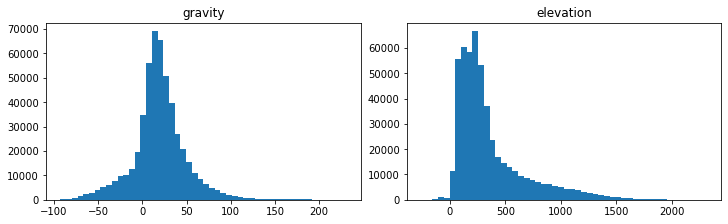

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 3))

# distribution of gravity data
plt.subplot(1, 2, 1)
plt.hist(x=df['grav'], bins=50)
plt.title('gravity')
    
# distribution of elevation data
plt.subplot(1, 2, 2)
plt.hist(x=df['elev'], bins=50)
plt.title('elevation')
plt.show()

Gravity has Gaussian distribution with positive skewness. Elevation data has Poisson spreading. There are negative values which suggests that the study area covers some depressions (beneath sea level).

### 1. Gravity Anomaly Map

In gravimetry, the free-air gravity anomaly is the measured gravity deviation after reducing the measured force of gravity at a given point to the reference surface (ellipsoid), without taking into account the mass between the elevation and the reference surface. The free-air correction is given by equation:

$$\delta g_F = - \frac{\partial g}{\partial h} \times h .$$

The real value of the vertical gravity gradient is rarely given. We usually use the gradient of normal gravity which can be obatained by formula:

$$\frac{\partial \gamma}{\partial h} = - \gamma \times (\frac{1}{M} + \frac{1}{N}) - 2\omega ^2 = -\frac{2 \gamma}{a}(1 + f + q - 2f \sin^2 B) .$$

However, we mostly use the mean global value for Earth, which is enough for geodetic purposes:

$$\delta g_F \approx 0.3086 \times h ,$$

where $h$ is the height from the reference surface, to the given point. Finally, the free-air anomaly is given by:

$$\Delta g_F = g - \gamma_e + \delta g_F ,$$

where $g$ is the measured gravity and $𝛾_e$ is the theoretical gravity at given latitude - both in minigals [mGal]. Note that *anomaly* and *gravity reduction* are different statements. The free-air gravity anomalies were taken from the Topex dataset.

In [4]:
# scaling and centering colorbar for better presentation - with 0.0 value in middle
import matplotlib.colors as colors
import numpy as np

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

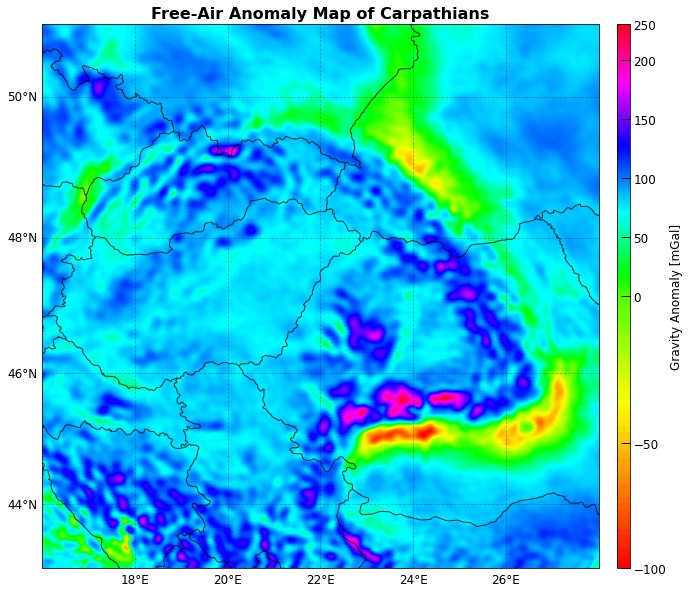

In [5]:
# main plot properties
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((16, 28, 43, 51))

# delete margins/white spaces
plt.margins(0)

# defining values for colorbar
min_val = min(df['grav'])
max_val = max(df['grav'])
mid_val = 0.0

# colormap normalization
norm = MidpointNormalize(vmin=min_val, vmax=max_val, midpoint=mid_val)

# baseplot
plt.scatter(x=df['long'], y=df['lat'], c=df['grav'], cmap='hsv', clim=(min_val, max_val),
            norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = plt.colorbar(pad=.02, aspect=40, orientation='vertical')
cbar.set_label(label='Gravity Anomaly [mGal]', size=12)
cbar.ax.tick_params(labelsize=12, direction='in', size=9, width=1)

# title
plt.title('Free-Air Anomaly Map of Carpathians', size=16, weight='bold')

# gridlines
mloc = plt.MultipleLocator(2)
gl = ax.gridlines(draw_labels=True, xlocs=mloc, ylocs=mloc, dms=True, crs=ccrs.PlateCarree(), color='black',
                  alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# country borders
bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='10m',
                                    facecolor='none', alpha=0.7)
ax.add_feature(bodr, linestyle='-', edgecolor='black', alpha=0.8)
plt.show()

### 2. Elevation Map

The surveying points were obtained from satellite missions (altimetry). No further transformations are required in this notebook.

For a better presentation, we will introduce the borders of the countries covered by the mountain range. We will also implement a map projection for preserving local directions and shapes (Mercator projection).

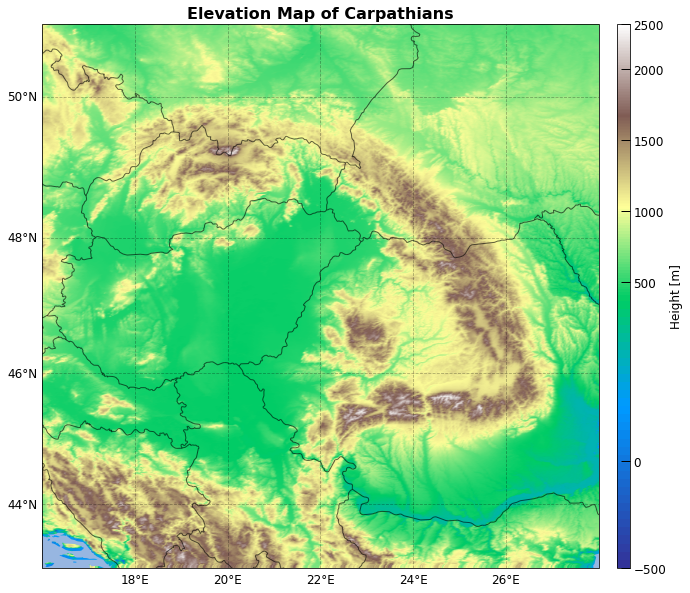

In [6]:
# main plot properties
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((16, 28, 43, 51))

# delete margins/white spaces
plt.margins(0)

# colormap normalization
norm = MidpointNormalize(vmin=None, vmax=None, midpoint=400)

# baseplot
plt.scatter(x=df['long'], y=df['lat'], c=df['elev'], cmap='terrain', norm=norm, transform=ccrs.PlateCarree())

# colorbar
cbar = plt.colorbar(pad=.02, aspect=40, orientation='vertical')
cbar.set_label(label='Height [m]', size=12)
cbar.ax.tick_params(labelsize=12, direction='in', size=9, width=1)

# title
plt.title('Elevation Map of Carpathians', size=16, weight='bold')

# gridlines
mloc = plt.MultipleLocator(2)
gl = ax.gridlines(draw_labels=True, xlocs=mloc, ylocs=mloc, dms=True, crs=ccrs.PlateCarree(), color='black',
                  alpha=0.3, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# country borders
bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', scale='10m',
                                    facecolor='none', alpha=0.7)
ax.add_feature(bodr, linestyle='-', edgecolor='black', alpha=0.6)

# ocean
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale='10m', edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(ocean, linewidth=0.2)
plt.show()

### 3. Geoid Undulation Map

The geoid is approximately the shape that the ocean surface would take under the influence of the gravity of Earth, which also includes: tides, gravitational attraction, and planet rotation. It is in essence an equipotential surface of the actual (or local) gravitational field. This infinite surface is also dynamic, meaning its undulations have spatial changes in time. The geoid is usually given as heights with respect to a reference ellipsoid and is calculated using gravity observations. The concept of the geoid can be represented by this figure:

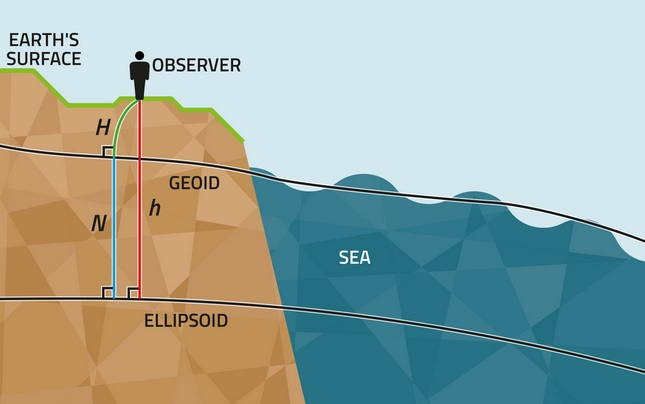

$$N = h - H$$

where $H$ is the orthometric height, $h$ is the ellipsoidal height or survey based height, and $N$ is the geoid height (geoid anomaly or geoid undulation). The geoid height is the normal distance between the ellipsoid and the surface of the geoid and the orthometric height is referred as mean sea level height.

Although, this equation is simple, calculating the geoid height is actually very complex and mathematically challenging. We need additionally much more information, such as: spherical harmonic coefficients, local vertical deflections, gravity field, or Earth's mass distribution. Geoid computation is performed with several methods, e.g. astronomical-topographic levelling, least squares collocation, and neural networks.

Another and much more simpler method for finding $N$ and $H$ is through interpolation in a grid of values for the Earth gravity models (EGM). These geoid models contain normalized, geopotential coefficients used in a spherical harmonic expansion to create a global potential surface to coincide with mean sea level. EGM's are referenced to the WGS 84 ellipsoid and are published by the National Geospatial-Intelligence Agency (NGA).

For this specific case we will use the EGM2008 geoid model with a 5' grid avaiable on UNAVCO website (https://www.unavco.org/software/geodetic-utilities/geoid-height-calculator/geoid-height-calculator.html). Since our topographic data is much more dense with a 1' grid, we will need to interpolate height values. We will use cubic interpolation to obtain more accurate output. It is estimated that for cubic interpolation the RMS error for geoid height is 4.5 mm, and 0.294 m for maximum error (source: https://geographiclib.sourceforge.io/C++/doc/GeoidEval.1.html).

In [7]:
# saving to CSV file with chosen columns in rearranged column order
df[['lat', 'long', 'elev']].to_csv('unavco_file.csv', header=['lat', 'long', 'elev'], index=False)

In [8]:
# loading new CSV file with heights
df_unavco = pd.read_csv('geoid_height_2022-08-09.csv')
df_unavco.head(10)

,Latitude,Longitude,Ellps Height (m),Geoid Height (m),Ortho Height (m)
0,50.9968,16.0083,393,40.15,352.85
1,50.9968,16.0250,383,42.13,340.87
2,50.9968,16.0417,367,44.21,322.79
3,50.9968,16.0583,351,46.39,304.61
4,50.9968,16.0750,349,48.75,300.25
5,50.9968,16.0917,329,40.05,288.95
6,50.9968,16.1083,371,42.00,329.00
7,50.9968,16.1250,367,44.07,322.93
8,50.9968,16.1417,287,46.26,240.74
9,50.9968,16.1583,237,48.59,188.41


In [9]:
# creating new meshgrid from pivot table
Z = df_unavco.pivot_table(index='Longitude', columns='Latitude', values='Geoid Height (m)').T.values

xx = np.sort(df_unavco['Longitude'].unique())
yy = np.sort(df_unavco['Latitude'].unique())
X, Y = np.meshgrid(xx, yy)

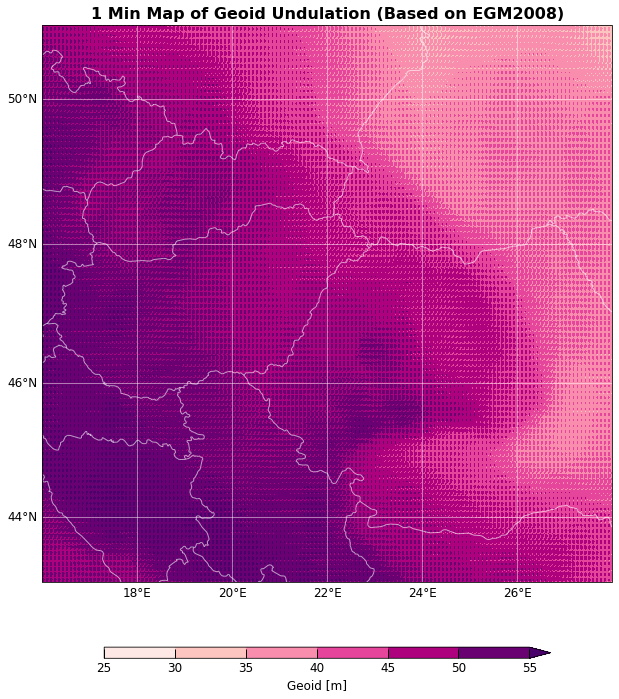

In [10]:
# main plot properties
fig = plt.figure(figsize=(16, 12))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent((16, 28, 43, 51))

# delete margins/white spaces
plt.margins(0)

# baseplot
levels = [25, 30, 35, 40, 45, 50, 55]
plt.contourf(X, Y, Z, extend='max', cmap='RdPu', levels=levels, transform=ccrs.PlateCarree())

# colorbar
cbar = plt.colorbar(pad=0.1, aspect=40, orientation='horizontal', fraction=0.046, shrink=0.5)
cbar.set_label(label='Geoid [m]', size=12)
cbar.ax.tick_params(labelsize=12, direction='in', size=9, width=1)

# title
plt.title('1 Min Map of Geoid Undulation (Based on EGM2008)', size=16, weight='bold')

# gridlines
mloc = plt.MultipleLocator(2)
gl = ax.gridlines(draw_labels=True, xlocs=mloc, ylocs=mloc, dms=True, crs=ccrs.PlateCarree(), color='white',
                  alpha=0.6, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}

# country borders
bodr = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land',
                                    scale='10m', facecolor='none', alpha=0.7)
ax.add_feature(bodr, edgecolor='white', alpha=0.6)
plt.show()

### 4. Geoid's Profiles

The last step of modelling Carpathian's geoid will be plotting its profiles in two sections - latitude and longitude. We will implement a function that draws a spline of the geoid's profile. We will apply a Savitzky-Golay filter into the function. This filter allows us to smooth data to create an approximating curve of the section, without noisy values.

In [11]:
def plot_geoid_profile(lat=None, long=None):
    
    # module for smoothing splines
    from scipy.signal import savgol_filter
    
    # 1. no arguments passed
    if lat is None and long is None:
        raise ValueError('You must pass at least one argument!')
    
    # 2. too much arguments - function accepts only one
    elif lat is not None and long is not None:
        raise ValueError('Too many arguments - choose one profile!')
    
    # 3. cross section profile E-W
    elif lat is not None and long is None:
        df = df_unavco.loc[df_unavco['Latitude'] == lat]
        x = df['Longitude'].values
        N = df['Geoid Height (m)'].values
        yhat = savgol_filter(x=N, window_length=135, polyorder=3)

        # plot
        plt.figure(figsize=(12, 4))
        plt.plot(x, yhat, color='red', linestyle='--')
        plt.title('Geoid Profile Along Prime Vertical (E-W Direction)', weight='bold')
        plt.xlabel('Longitude [$^{\circ}$]')
        plt.ylabel('Geoid Height (m)')
        plt.grid(axis='y')
        plt.show()
    
    # 4. longitudinal section profile N-S
    elif long is not None and lat is None:
        df = df_unavco.loc[df_unavco['Longitude'] == long]
        x = df['Latitude'].values
        N = df['Geoid Height (m)'].values
        yhat = savgol_filter(x=N, window_length=135, polyorder=3)

        # plot
        plt.figure(figsize=(10, 4))
        plt.plot(x, yhat, color='red', linestyle='--')
        plt.title('Geoid Profile Along Meridian (N-S Direction)', weight='bold')
        plt.xlabel('Latitude [$^{\circ}$]')
        plt.ylabel('Geoid Height (m)')
        plt.grid(axis='y')
        plt.show()

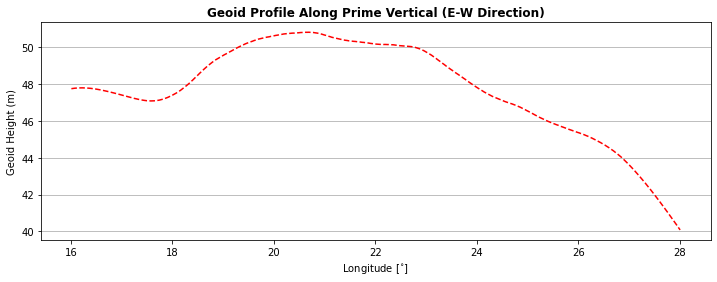

In [12]:
# example for latitude
plot_geoid_profile(lat=43.0050)

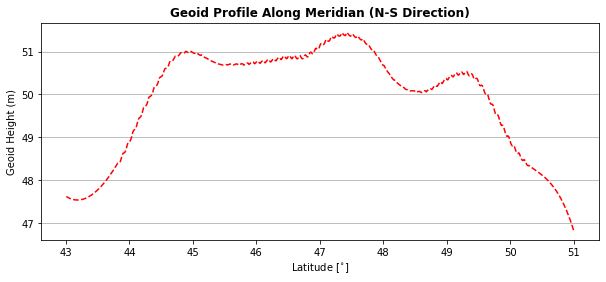

In [13]:
# example for longitude
plot_geoid_profile(long=16.1417)

### 5. Conclusions

Earth gravitational models are significant to transform the GNSS ellipsoidal heights into undulation and orthometric heights which are widely used in GIS, geomatics, higher geodesy, and surveying applications. The geoid displays Earth's irregular geopotential. This notebook has investigated how geoid determination can be performed without complex calculations. We used UNAVCO's website software and cubic interpolation technique to obtain values between nodes.

The area of interest within Central Europe was chosen to create a geoid map for the Carpathian region. We also successfully developed a function that visualizes curves of the local geoid in its two prime sections.

**References**

1. Abdulrahman F.H., *Determination of the local geoid model in Duhok Region, University of Duhok Campus as a Case study*, Ain Shams Engineering Journal, Volume 12, Issue 2, June 2021, pp. 1293-1304
2. Czarnecki K., 1994, *Geodezja współczesna w zarysie*, ISBN 83-86805-67-6
3. Osada E., 2016, *Geodezyjne układy odniesienia*, Wydanie 3, ISBN 978-83-60221-11-2
4. https://www.britannica.com/science/geoid/The-concept-of-the-geoid [Accessed 9th August 2022]
5. https://www.maanmittauslaitos.fi/en/research/interesting-topics/geoid [Accessed 9th August 2022]